In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',None)
import datetime
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
from scipy import stats
import math
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib notebook
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
#mpl.use('TkAgg')  # 该行代码可以将图像变成自动弹出，若注释掉则在database中生成不弹出
mpl.rcParams['axes.unicode_minus'] = False  # 设置负号的表示方式


# import dolphindb as ddb
# HOST = "10.0.78.11"
# PORT = 8930

# s = ddb.session()
# s.connect(HOST, PORT, "admin", "123456")

In [2]:
#dataframe数据导出为pickle
#单个pickle下载少于等于五千万个数据
def pickle_dump(df,file_path,file_name,single_size = 5e+7):
    df_size = df.size
    df_row, df_column = df.shape
    
    if df_size > single_size:
        #单个文件行数
        single_row =  math.floor(single_size / df_column)
        #需要多少个文件来储存
        document_num = math.ceil(df_row / single_row)
        for i in range(1,document_num+1):
            with open(os.path.join(file_path,file_name+str(i)+'.pkl'), 'wb') as file:
                if i == 1:
                    pickle.dump(df.iloc[:single_row,], file) 
                if i == document_num:
                    pickle.dump(df.iloc[single_row*(document_num-1):,], file)
                else:
                    pickle.dump(df.iloc[single_row*(i-1):single_row*i,], file)
    else:
        #仅需1个pickle
        with open(os.path.join(file_path,file_name+'.pkl'), 'wb') as file:
            pickle.dump(df, file)
            

#dataframe数据从pickle导入
def pickle_load(file_path,file_name):
    documents = os.listdir(file_path)
    required_documents = []
    for i in documents:
        if i[:len(file_name)] == file_name:
            required_documents.append(i)
            
    if len(required_documents) > 1:
        df = pd.DataFrame()
        for i in range(1,len(required_documents)+1):
            with open(os.path.join(file_path,file_name+str(i)+'.pkl'), 'rb') as file:
                df_partly = pickle.load(file)
            df = pd.concat([df,df_partly],axis=0)
    else:
        with open(os.path.join(file_path,file_name+'.pkl'), 'rb') as file:
            df = pickle.load(file)
            
    return df

#示例
#pickle_dump(df = stock_info ,file_path = 'E:/python_big_data/stock_daily_information',file_name = 'stock_info')
#stock_info = pickle_load(file_path = 'E:/python_big_data/stock_daily_information',file_name = 'stock_info')

In [14]:
stock_info = pickle_load(file_path = 'E:/python_big_data/stock_daily_information',file_name = 'stock_info')

In [15]:
stock_info

,S_INFO_WINDCODE,TRADE_DT,S_DQ_AVGPRICE,S_DQ_CLOSE,CITICS_IND_NAME,is_listed_6m,is_ST,is_suspend,is_limit_up,is_limit_down,S_DQ_MV,SUE
0,000001.SZ,2010-01-04,23.9849,23.71,银行,1,1,1,1,1,6.933075e+06,0.60072
1,000001.SZ,2010-01-05,23.2431,23.30,银行,1,1,1,1,1,6.813186e+06,0.60072
2,000001.SZ,2010-01-06,22.9157,22.90,银行,1,1,1,1,1,6.696222e+06,0.60072
3,000001.SZ,2010-01-07,22.6311,22.65,银行,1,1,1,1,1,6.623119e+06,0.60072
4,000001.SZ,2010-01-08,22.5501,22.60,银行,1,1,1,1,1,6.608498e+06,0.60072
...,...,...,...,...,...,...,...,...,...,...,...,...
10852410,689009.SH,2023-11-02,33.2364,32.92,机械,1,1,1,1,1,1.723282e+06,NaN
10852411,689009.SH,2023-11-03,33.5103,33.42,机械,1,1,1,1,1,1.749455e+06,NaN
10852412,689009.SH,2023-11-06,33.5170,33.59,机械,1,1,1,1,1,1.758354e+06,NaN
10852413,689009.SH,2023-11-07,33.0135,32.95,机械,1,1,1,1,1,1.724852e+06,NaN


In [24]:
#复权因子
adj_close_factor = pickle_load(file_path = 'E:/python_big_data/stock_daily_information',file_name = 'adj_close_factor')
stock_info = pd.merge(stock_info,adj_close_factor,how='left')
stock_info['S_DQ_AVGPRICE'] = stock_info['S_DQ_AVGPRICE']*stock_info['S_DQ_ADJFACTOR']
stock_info['S_DQ_CLOSE'] = stock_info['S_DQ_CLOSE']*stock_info['S_DQ_ADJFACTOR']
stock_info = stock_info.drop('S_DQ_ADJFACTOR',axis=1)

In [23]:
stock_info

,S_INFO_WINDCODE,TRADE_DT,S_DQ_AVGPRICE,S_DQ_CLOSE,CITICS_IND_NAME,is_listed_6m,is_ST,is_suspend,is_limit_up,is_limit_down,S_DQ_MV,SUE
0,000001.SZ,2010-01-04,861.190690,851.320259,银行,1,1,1,1,1,6.933075e+06,0.60072
1,000001.SZ,2010-01-05,834.555964,836.598989,银行,1,1,1,1,1,6.813186e+06,0.60072
2,000001.SZ,2010-01-06,822.800491,822.236774,银行,1,1,1,1,1,6.696222e+06,0.60072
3,000001.SZ,2010-01-07,812.581776,813.260390,银行,1,1,1,1,1,6.623119e+06,0.60072
4,000001.SZ,2010-01-08,809.673427,811.465114,银行,1,1,1,1,1,6.608498e+06,0.60072
...,...,...,...,...,...,...,...,...,...,...,...,...
10852410,689009.SH,2023-11-02,33.236400,32.920000,机械,1,1,1,1,1,1.723282e+06,NaN
10852411,689009.SH,2023-11-03,33.510300,33.420000,机械,1,1,1,1,1,1.749455e+06,NaN
10852412,689009.SH,2023-11-06,33.517000,33.590000,机械,1,1,1,1,1,1.758354e+06,NaN
10852413,689009.SH,2023-11-07,33.013500,32.950000,机械,1,1,1,1,1,1.724852e+06,NaN


In [25]:
#2010至今的交易日
trade_date = pickle_load(file_path = 'E:/python_big_data/stock_daily_information',file_name = 'trade_date')
#因子日 期末截面日
factor_day_dict = {} 
for i in range(0, len(trade_date), 20):
    factor_day_dict[trade_date[i]] = i
#调仓日
rebalance_day_dict = {}
for i in range(1, len(trade_date), 20):
    rebalance_day_dict[trade_date[i]] = i-1
#调仓日 reverse
rebalance_day_dict_reverse = {v: k for k, v in rebalance_day_dict.items()}

In [26]:
#新建close列 将调仓日close设置为vwap（S_DQ_AVGPRICE），其他日close为S_DQ_CLOSE
stock_info1 = stock_info[stock_info['TRADE_DT'].isin(list(rebalance_day_dict.keys()))]
stock_info2 = stock_info[~(stock_info['TRADE_DT'].isin(list(rebalance_day_dict.keys())))]
stock_info1 = stock_info1.drop(['S_DQ_CLOSE'], axis=1)
stock_info1 = stock_info1.rename(columns={'S_DQ_AVGPRICE':'close'})
stock_info2 = stock_info2.drop(['S_DQ_AVGPRICE'], axis=1)
stock_info2 = stock_info2.rename(columns={'S_DQ_CLOSE':'close'})
stock_info3 = pd.concat([stock_info1,stock_info2],axis=0)
stock_info3 = stock_info3.sort_values(['S_INFO_WINDCODE','TRADE_DT']).reset_index(drop=True)
#剔除ST、不满六个月
stock_info3 = stock_info3[(stock_info3['is_ST']==1)&(stock_info3['is_listed_6m']==1)].reset_index(drop=True)
stock_info3

,S_INFO_WINDCODE,TRADE_DT,close,CITICS_IND_NAME,is_listed_6m,is_ST,is_suspend,is_limit_up,is_limit_down,S_DQ_MV,SUE
0,000001.SZ,2010-01-04,851.320259,银行,1,1,1,1,1,6.933075e+06,0.60072
1,000001.SZ,2010-01-05,834.555964,银行,1,1,1,1,1,6.813186e+06,0.60072
2,000001.SZ,2010-01-06,822.236774,银行,1,1,1,1,1,6.696222e+06,0.60072
3,000001.SZ,2010-01-07,813.260390,银行,1,1,1,1,1,6.623119e+06,0.60072
4,000001.SZ,2010-01-08,811.465114,银行,1,1,1,1,1,6.608498e+06,0.60072
...,...,...,...,...,...,...,...,...,...,...,...
10058118,689009.SH,2023-11-02,32.920000,机械,1,1,1,1,1,1.723282e+06,NaN
10058119,689009.SH,2023-11-03,33.420000,机械,1,1,1,1,1,1.749455e+06,NaN
10058120,689009.SH,2023-11-06,33.517000,机械,1,1,1,1,1,1.758354e+06,NaN
10058121,689009.SH,2023-11-07,32.950000,机械,1,1,1,1,1,1.724852e+06,NaN


#### 因子预处理

In [27]:
####因子预处理函数####
#中位数去极值 
def Median_De_Outlier(df,date_name,factor_list):
    df = df.copy()
    for i in factor_list:
        df.loc[:, 'MD'] = df.groupby(date_name)[i].transform('median') # 获取中位数
        df.loc[:, 'abs_MD'] = abs(df[i] - df['MD'])  
        
        df.loc[:, 'MAD'] = df.groupby(date_name)['abs_MD'].transform('median')  #绝对中位差值

        df.loc[df[i] > df['MD'] + 3 * 1.483 * df['MAD'], i] = df['MD'] + 3 * 1.483 * df['MAD']#去极值
        df.loc[df[i] < df['MD'] - 3 * 1.483 * df['MAD'], i] = df['MD'] - 3 * 1.483 * df['MAD']
        df.drop(['MD','abs_MD','MAD'], axis=1,inplace=True)
    return df

# 缺失值处理  需已进行sort
def fill_missing(df,date_name,industry_name,factor_list):
    df = df.copy()
    for i in factor_list:
        # 截面-行业均值
        date_industry_mean = df.groupby([date_name, industry_name])[i].mean().reset_index()
        #若截面-行业均值存在缺失值，用截面均值填补
        if not date_industry_mean.loc[date_industry_mean.isna().any(axis=1)].empty:
            date_mean = df.groupby([date_name])[i].mean().reset_index()
            date_industry_mean = pd.merge(date_industry_mean, date_mean, on=[date_name], how='left') # 与截面因子均值进行合并
            date_industry_mean[i+'_x'] = np.where(date_industry_mean[i+'_x'].isna(),\
                                                  date_industry_mean[i+'_y'],date_industry_mean[i+'_x'])
            date_industry_mean = date_industry_mean.rename(columns={i+'_x': i}).drop(i+'_y',axis=1)
        #若截面-行业均值无缺失值
        else:
            df = pd.merge(df, date_industry_mean, on=[date_name, industry_name], how='left') # 与截面-行业因子均值进行合并
            df[i+'_x'] = np.where(df[i+'_x'].isna(),df[i+'_y'],df[i+'_x'])# 缺失处填补
            df = df.rename(columns={i+'_x': i}).drop(i+'_y',axis=1)
    return df

#行业市值中性化：先市值中性化再行业中性化 行业：中信一级行业  市值：对数流通市值
#市值中性化 先按截面groupby 后apply  且x与y长度应一致 无缺失值
def market_value_neutralized(df,factor_list_to_be_neutralized,market_value_name):
    df = df.copy()
    for i in factor_list_to_be_neutralized:
        X = df[market_value_name].values.reshape(-1, 1)  # 自变量，市值对数
        Y = df[i]  # 因变量
        reg = LinearRegression().fit(X, Y)  # 拟合模型
        y_predict = reg.predict(X)  # 预测值
        df[i] = df[i] - y_predict  #取残差作为新的因子值
    return df

#行业中性化
def industry_neutralized(df,factor_list_to_be_neutralized,industry_name):
    #行业虚拟变量矩阵
    industry_dummies = pd.get_dummies(df[industry_name], dtype=int)
    for i in factor_list_to_be_neutralized:
        X = industry_dummies  # 自变量，行业哑变量
        Y = df[i]  # 因变量
        reg = LinearRegression(fit_intercept=False).fit(X, Y)  # 拟合模型  避免多重共线性
        y_predict = reg.predict(X)  # 预测值
        df[i] = df[i] - y_predict  #取残差作为新的因子值
    return df

#标准化
def fator_normalized(df,factor_list):
    df = df.copy()
    for i in factor_list:
        df[i] = (df[i] - df[i].mean()) / df[i].std()
    return df

In [28]:
#处理市值
stock_info4 = stock_info3.copy() #.loc[stock_info3.TRADE_DT<='20150101'] .loc[stock_info3.TRADE_DT=='20231106']
stock_info4['ln_DQ_MV'] = np.log(stock_info4['S_DQ_MV'])#对数流通市值
stock_info4 = Median_De_Outlier(stock_info4,date_name='TRADE_DT',factor_list=['ln_DQ_MV'])#市值去极值
stock_info4 = stock_info4.groupby('TRADE_DT').apply(fator_normalized,factor_list=['ln_DQ_MV'])#市值标准化

#因子去极值MAD
stock_info4 = Median_De_Outlier(stock_info4,date_name='TRADE_DT',factor_list=['SUE'])
#因子缺失值填充为行业均值
stock_info4 = fill_missing(stock_info4,date_name='TRADE_DT',industry_name='CITICS_IND_NAME',factor_list=['SUE'])
#因子标准化
stock_info4 = stock_info4.groupby('TRADE_DT').apply(fator_normalized,factor_list=['SUE'])
#因子市值行业中性化 先市值后行业
#市值
stock_info4 = stock_info4.sort_values(['TRADE_DT','S_INFO_WINDCODE']).reset_index(drop=True)
stock_info4 = stock_info4.groupby('TRADE_DT').apply(market_value_neutralized,factor_list_to_be_neutralized=['SUE'],market_value_name='ln_DQ_MV')
#行业
stock_info4 = stock_info4.groupby('TRADE_DT').apply(industry_neutralized,['SUE'],'CITICS_IND_NAME')
stock_info4 = stock_info4.sort_values(['S_INFO_WINDCODE','TRADE_DT']).reset_index(drop=True)
stock_info4

,S_INFO_WINDCODE,TRADE_DT,close,CITICS_IND_NAME,is_listed_6m,is_ST,is_suspend,is_limit_up,is_limit_down,S_DQ_MV,SUE,ln_DQ_MV
0,000001.SZ,2010-01-04,851.320259,银行,1,1,1,1,1,6.933075e+06,0.629921,2.663192
1,000001.SZ,2010-01-05,834.555964,银行,1,1,1,1,1,6.813186e+06,0.630144,2.665161
2,000001.SZ,2010-01-06,822.236774,银行,1,1,1,1,1,6.696222e+06,0.630290,2.657060
3,000001.SZ,2010-01-07,813.260390,银行,1,1,1,1,1,6.623119e+06,0.630973,2.660814
4,000001.SZ,2010-01-08,811.465114,银行,1,1,1,1,1,6.608498e+06,0.631163,2.681200
...,...,...,...,...,...,...,...,...,...,...,...,...
10058118,689009.SH,2023-11-02,32.920000,机械,1,1,1,1,1,1.723282e+06,0.026723,1.102108
10058119,689009.SH,2023-11-03,33.420000,机械,1,1,1,1,1,1.749455e+06,0.029538,1.107015
10058120,689009.SH,2023-11-06,33.517000,机械,1,1,1,1,1,1.758354e+06,0.031072,1.093893
10058121,689009.SH,2023-11-07,32.950000,机械,1,1,1,1,1,1.724852e+06,0.030663,1.072034


In [10]:
#pickle_dump(df = stock_info4 ,file_path = 'E:/python_big_data/stock_daily_info_processed',file_name = 'stock_info_processed')
stock_info4 = pickle_load(file_path = 'E:/python_big_data/stock_daily_info_processed',file_name = 'stock_info_processed')

#### 期末截面期

In [29]:
#选择截面期末的交易日
factor_data = stock_info4[stock_info4['TRADE_DT'].isin(list(factor_day_dict.keys()))].reset_index(drop=True)
factor_data['hold_period'] = factor_data['TRADE_DT'].map(factor_day_dict)

# #剔除下期收益率为nan
# factor_data = factor_data.dropna(subset=['20_day_return'])
factor_data

,S_INFO_WINDCODE,TRADE_DT,close,CITICS_IND_NAME,is_listed_6m,is_ST,is_suspend,is_limit_up,is_limit_down,S_DQ_MV,SUE,ln_DQ_MV,hold_period
0,000001.SZ,2010-01-04,851.320259,银行,1,1,1,1,1,6.933075e+06,0.629921,2.663192,0
1,000001.SZ,2010-02-01,762.633585,银行,1,1,1,1,1,6.210819e+06,0.627011,2.663731,20
2,000001.SZ,2010-03-08,856.347034,银行,1,1,1,1,1,6.974013e+06,0.390350,2.652836,40
3,000001.SZ,2010-04-06,839.112376,银行,1,1,1,1,1,6.833655e+06,1.560743,2.670686,60
4,000001.SZ,2010-05-05,714.520166,银行,1,1,1,1,1,5.818987e+06,-0.540190,2.713168,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505058,689009.SH,2023-07-06,36.450000,机械,1,1,1,1,1,1.865148e+06,0.030115,1.086884,3280
505059,689009.SH,2023-08-03,32.800000,机械,1,1,1,1,1,1.678377e+06,0.030447,0.983054,3300
505060,689009.SH,2023-08-31,33.410000,机械,1,1,1,1,1,1.709591e+06,0.051127,1.058595,3320
505061,689009.SH,2023-09-28,34.830000,机械,1,1,1,1,1,1.785209e+06,0.056602,1.102019,3340


#### 单因子检测

In [30]:
#因子分组 
#按照因子值从小到大分 10 组（P1-P10），每组成分股进行等权处理，因子值最大的一组P10作为多头，因子值最小的一组P1作为空头
def factor_grouping(df,date_name,factor_name,group_num):
    #从低到高排序
    df = df.groupby(date_name).apply(lambda x: x.sort_values(factor_name,ascending=True)).reset_index(drop=True)
    #分组
    df['Portfolio'] = df.groupby(date_name).apply(lambda x:pd.qcut(x[factor_name], \
                                q=group_num, labels=['P' + str(x) for x in range(1,group_num+1)])).reset_index(drop=True)
    return df
factor_data = factor_grouping(factor_data,'TRADE_DT','SUE',10)

#选择下一交易日可交易数据
factor_data = factor_data[(factor_data['is_suspend']==1)&(factor_data['is_limit_up']==1)].reset_index(drop=True)

#调仓日新股持仓表
rebalance_day_holding = factor_data[['hold_period','S_INFO_WINDCODE','TRADE_DT','Portfolio']]
rebalance_day_holding['rebalance_date'] = rebalance_day_holding['hold_period'].map(rebalance_day_dict_reverse)
rebalance_day_holding = rebalance_day_holding.drop(['TRADE_DT'], axis=1)
rebalance_day_holding = rebalance_day_holding[['hold_period','rebalance_date','S_INFO_WINDCODE','Portfolio']]

#rebalance_day_holding = rebalance_day_holding.loc[rebalance_day_holding.rebalance_date>=pd.to_datetime('20160101')]\
#.reset_index(drop=True)
# with open('factor_data.pkl', 'wb') as file:
#     pickle.dump(factor_data, file)
# with open('rebalance_day_holding.pkl', 'wb') as file:
#     pickle.dump(rebalance_day_holding, file)
rebalance_day_holding

,hold_period,rebalance_date,S_INFO_WINDCODE,Portfolio
0,0,2010-01-05,000602.SZ,P1
1,0,2010-01-05,002126.SZ,P1
2,0,2010-01-05,000957.SZ,P1
3,0,2010-01-05,600312.SH,P1
4,0,2010-01-05,002111.SZ,P1
...,...,...,...,...
486797,3360,2023-11-06,688636.SH,P10
486798,3360,2023-11-06,688510.SH,P10
486799,3360,2023-11-06,600737.SH,P10
486800,3360,2023-11-06,601088.SH,P10


In [31]:
#计算组合日频净值 
def calculate_portfolio_daily_net_value(df,portfolio_name,general_table=stock_info4):
    #组合信息日频化
    portfolio_stock_info = df[df['Portfolio']==portfolio_name][['S_INFO_WINDCODE','rebalance_date']]\
        .sort_values(['S_INFO_WINDCODE','rebalance_date']).reset_index(drop=True)
    portfolio_stock_info['date_list'] = portfolio_stock_info['rebalance_date']\
        .apply(lambda x: trade_date[(trade_date.index(x)):(trade_date.index(x) + 21)])
    portfolio_stock_info = portfolio_stock_info.explode('date_list')
    portfolio_stock_info = portfolio_stock_info.rename(columns={'date_list': 'TRADE_DT'})
    portfolio_stock_info['hold_period'] = portfolio_stock_info['rebalance_date'].map(rebalance_day_dict)
    #打标签
    portfolio_stock_info['rd_equal_td'] = np.where(portfolio_stock_info['rebalance_date'] == portfolio_stock_info['TRADE_DT'],1,0)
    portfolio_stock_info['is_rebalance_date'] = np.where(portfolio_stock_info['TRADE_DT'].isin(list(rebalance_day_dict.keys())),1,0)
    
    #总表的个股日收益率数据
    stock_daily_return = general_table[['S_INFO_WINDCODE','TRADE_DT','close']]
    stock_daily_return['daily_return'] = stock_daily_return.groupby('S_INFO_WINDCODE')['close'].pct_change(1)

    #合并收益率
    portfolio_stock_info = pd.merge(portfolio_stock_info,stock_daily_return,how='left')
    portfolio_stock_info = portfolio_stock_info.sort_values(['hold_period','S_INFO_WINDCODE','TRADE_DT'])\
        .dropna(subset=['close']).reset_index(drop=True)
    
    #单期个股净值
    portfolio_stock_info['daily_return'] = np.where(portfolio_stock_info['rd_equal_td'] == 1,0,portfolio_stock_info['daily_return'])
    portfolio_stock_info['stock_net_value'] = portfolio_stock_info.groupby(['hold_period','S_INFO_WINDCODE'])['daily_return']\
        .apply(lambda x: (x+1).cumprod())
    
    #单期组合净值
    portfolio_stock_info['aver_net_value'] = portfolio_stock_info.groupby(['hold_period','TRADE_DT'])['stock_net_value'].transform('mean')
    portfolio_performance = portfolio_stock_info[portfolio_stock_info['rd_equal_td']==0]\
        [['TRADE_DT','hold_period','is_rebalance_date','aver_net_value']]
    portfolio_performance = portfolio_performance.drop_duplicates().reset_index(drop=True)
    
    pre_net_value = 1
    for i in portfolio_performance.index:
        portfolio_performance.loc[i,portfolio_name+'_net_value'] = pre_net_value * portfolio_performance.loc[i,'aver_net_value']
        if portfolio_performance.loc[i,'is_rebalance_date'] == 1:
            pre_net_value = portfolio_performance.loc[i,portfolio_name+'_net_value']
            
    portfolio_performance = portfolio_performance[['hold_period','TRADE_DT',portfolio_name+'_net_value']]
    new_row = pd.DataFrame([[0,pd.to_datetime('20100105'),1]], columns=portfolio_performance.columns)
    portfolio_performance = pd.concat([new_row, portfolio_performance], ignore_index=True)
    
    #组合日收益率
    portfolio_performance[portfolio_name+'_ret_daily'] = portfolio_performance[portfolio_name+'_net_value'].pct_change().fillna(0)
    
    return portfolio_performance

In [32]:
long_portfolio_nv = calculate_portfolio_daily_net_value(rebalance_day_holding,portfolio_name='P10',general_table=stock_info4)
long_portfolio_nv

,hold_period,TRADE_DT,P10_net_value,P10_ret_daily
0,0,2010-01-05,1.000000,0.000000
1,0,2010-01-06,1.005308,0.005308
2,0,2010-01-07,0.983789,-0.021405
3,0,2010-01-08,0.994137,0.010518
4,0,2010-01-11,1.000646,0.006548
...,...,...,...,...
3358,3340,2023-11-02,5.717629,-0.010118
3359,3340,2023-11-03,5.786696,0.012080
3360,3340,2023-11-06,5.871014,0.014571
3361,3360,2023-11-07,5.926559,0.009461


In [33]:
#多头表现
def calculate_long_portfolio_performance(df,portfolio_name='P10'):
    #年化收益
    days = (df['TRADE_DT'].max() - df['TRADE_DT'].min()).days
    annualized_ret = (df.loc[:, portfolio_name+'_net_value'].iloc[-1] - 1) * (252/days)

    #年化波动率
    annualized_volatility = np.std(df[portfolio_name+'_ret_daily'].iloc[1:])*np.sqrt(252)

    #夏普比率
    sharpe_ratio = annualized_ret/annualized_volatility

    #最大回撤
    maximum_drawdown = (df[portfolio_name+'_net_value'] / df[portfolio_name+'_net_value'].cummax() - 1).min() # 超额收益最大回撤
    maximum_drawdown
    
    #换手率均值 用到factor_data
    portfolio_holding = factor_data[factor_data['Portfolio']==portfolio_name][['hold_period','S_INFO_WINDCODE']]\
            .sort_values(['hold_period','S_INFO_WINDCODE']).reset_index(drop=True)
    
    period = list(portfolio_holding['hold_period'].unique())
    turnover_rate = []
    for i in range(len(period)-1):
        #前后两期持仓
        holding1 = portfolio_holding[portfolio_holding['hold_period']==period[i]]['S_INFO_WINDCODE'].to_list()
        holding2 = portfolio_holding[portfolio_holding['hold_period']==period[i+1]]['S_INFO_WINDCODE'].to_list()
        #每期股票数
        stock_num =portfolio_holding[portfolio_holding['hold_period']==period[i]].shape[0]
        #计算当期有多少股票不在下一期
        stock_change_num = sum(1 for stock in holding1 if stock not in holding2)
        #换手率
        turnover_rate.append(stock_change_num/stock_num)
    average_turnover_rate = np.mean(turnover_rate)
    
    portfolio_performance_indicator = pd.DataFrame({'年化收益率': '{:.3%}'.format(annualized_ret),
                                                    '年化波动率': '{:.3f}'.format(annualized_volatility),
                                                    '夏普比率': '{:.3f}'.format(sharpe_ratio),
                                                    '最大回撤': '{:.3f}'.format(maximum_drawdown),
                                                    '平均换手率': '{:.2%}'.format(average_turnover_rate)
                                                   },index=[portfolio_name])
    #净值曲线
    fig, ax = plt.subplots(1, 1)
    #plt.plot([x for x in range(len(turnover_rate))],turnover_rate, 'r-', label=portfolio_name)
    plt.plot(df['TRADE_DT'],df[portfolio_name+'_net_value'], 'r-', label=portfolio_name)
    plt.ylabel('净值走势')  
    plt.legend()
    plt.show()
    return portfolio_performance_indicator

<IPython.core.display.Javascript object>


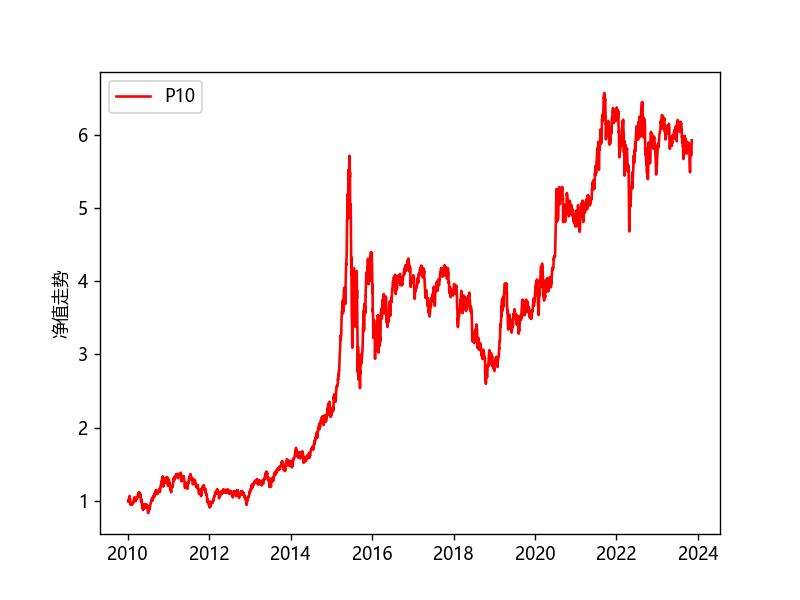

,年化收益率,年化波动率,夏普比率,最大回撤,平均换手率
P10,24.572%,0.270,0.911,-0.556,23.22%


In [34]:
long_portfolio_performance=calculate_long_portfolio_performance(long_portfolio_nv)
long_portfolio_performance

In [35]:
#计算IC
#计算n日收益率需先sort_values
def calculate_n_day_return(df,n):
   df[str(n)+'_day_return'] = df.groupby('S_INFO_WINDCODE')['close'].pct_change(n).shift(-n)
   return df

stock_info4 = calculate_n_day_return(stock_info4,n=5)
stock_info4 = calculate_n_day_return(stock_info4,n=10)
stock_info4 = calculate_n_day_return(stock_info4,n=20)

In [36]:
stock_info4

,S_INFO_WINDCODE,TRADE_DT,close,CITICS_IND_NAME,is_listed_6m,is_ST,is_suspend,is_limit_up,is_limit_down,S_DQ_MV,SUE,ln_DQ_MV,5_day_return,10_day_return,20_day_return
0,000001.SZ,2010-01-04,851.320259,银行,1,1,1,1,1,6.933075e+06,0.629921,2.663192,-0.046816,-0.094475,-0.104175
1,000001.SZ,2010-01-05,834.555964,银行,1,1,1,1,1,6.813186e+06,0.630144,2.665161,-0.034122,-0.043587,-0.068993
2,000001.SZ,2010-01-06,822.236774,银行,1,1,1,1,1,6.696222e+06,0.630290,2.657060,-0.084716,-0.066376,-0.013974
3,000001.SZ,2010-01-07,813.260390,银行,1,1,1,1,1,6.623119e+06,0.630973,2.660814,-0.074172,0.001325,-0.019868
4,000001.SZ,2010-01-08,811.465114,银行,1,1,1,1,1,6.608498e+06,0.631163,2.681200,-0.051770,0.021239,-0.026549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10058118,689009.SH,2023-11-02,32.920000,机械,1,1,1,1,1,1.723282e+06,0.026723,1.102108,NaN,NaN,NaN
10058119,689009.SH,2023-11-03,33.420000,机械,1,1,1,1,1,1.749455e+06,0.029538,1.107015,NaN,NaN,NaN
10058120,689009.SH,2023-11-06,33.517000,机械,1,1,1,1,1,1.758354e+06,0.031072,1.093893,NaN,NaN,NaN
10058121,689009.SH,2023-11-07,32.950000,机械,1,1,1,1,1,1.724852e+06,0.030663,1.072034,NaN,NaN,NaN


In [37]:
####单因子检测函数####   
#计算RankIC和IC等指标
def calculate_IC(df,factor_name,day_list=[5,10,20]):
    IC_performance = pd.DataFrame()
    for n in day_list:
        df = df.copy().dropna(subset=[str(n)+'_day_return']).reset_index(drop=True)
        # 按组进行groupby操作，并计算每个组的IC和RankIC
        grouped = df.groupby('TRADE_DT')
        IC_list = []
        RankIC_list = []
        for group, df_group in grouped:
            IC, _ = stats.pearsonr(df_group[factor_name], df_group[str(n)+'_day_return'])
            RankIC, _ = stats.spearmanr(df_group[factor_name], df_group[str(n)+'_day_return'])
            IC_list.append(IC)
            RankIC_list.append(RankIC)

        #计算均值
        mean_IC = np.mean(IC_list)
        mean_RankIC = np.mean(RankIC_list)
        #计算IR
        IR_IC = mean_IC / np.std(IC_list)
        IR_RankIC = mean_RankIC / np.std(RankIC_list)
        #计算调仓胜率
        win_rate_IC = len([x for x in IC_list if x > 0]) / len(IC_list)
        win_rate_RankIC = len([x for x in RankIC_list if x > 0]) / len(RankIC_list)

        factor_test_indicator = pd.DataFrame({'RankIC均值': '{:.2%}'.format(mean_RankIC),
                                              'RankIC-调仓胜率': '{:.2%}'.format(win_rate_RankIC),
                                              'RankIC-IR': IR_RankIC,
                                              'IC均值': '{:.2%}'.format(mean_IC),
                                              'IC-调仓胜率': '{:.2%}'.format(win_rate_IC),
                                              'IC-IR': IR_IC}, index=[factor_name+'_'+str(n)])
        IC_performance = pd.concat([IC_performance,factor_test_indicator],axis=0)
    return IC_performance

In [38]:
calculate_IC(stock_info4,'SUE',day_list=[5,10,20])

,RankIC均值,RankIC-调仓胜率,RankIC-IR,IC均值,IC-调仓胜率,IC-IR
SUE_5,1.45%,66.15%,0.372388,1.30%,65.70%,0.358874
SUE_10,1.88%,69.26%,0.452802,1.71%,68.13%,0.439033
SUE_20,2.41%,71.44%,0.544073,2.23%,70.63%,0.533964
